<a href="https://colab.research.google.com/github/arzoozehra/CIND820/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
#!pip install contractions
import contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
#!pip install pyspellchecker
#from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Load data**

In [2]:
url = 'https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/train.csv'
train = pd.read_csv(url)
test = pd.read_csv('https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/test.csv')

**Explore data**

In [3]:
# Remove row with missing values
train.dropna(inplace=True)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [5]:
test['sentiment'].value_counts(normalize=True)

neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64

In [6]:
neutral = train[train['sentiment']=='neutral']
pos = train[train['sentiment']=='positive']
neg = train[train['sentiment']=='negative']

**Clean text**

In [7]:
# Convert text to lowercase
train['text'] = train['text'].str.lower()

# Expand contractions e.g "gonna" to "going to" and "i've" to "i have"
train['text'].replace( {r"`": "'"}, inplace= True, regex = True)
train['text'] = train['text'].apply(contractions.fix)

# Remove @, Unicode characters, punctuation, emojis, URLs, retweets, words with digits, and 1 or 2 letter words
train['text'].replace( {r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|\w*\d\w*|\b\w{1,2}\b": " "}, inplace= True, regex = True)

# Remove extra whitespaces
train['text'].replace( {r" +": " "}, inplace= True, regex = True)
train['text'] = train['text'].str.strip()

# Correct spellings
#spell = SpellChecker()

#def correct_spellings(text):
#    corrected_text = []
#    misspelled_words = {}
#    words = text.split()
#    for w in spell.unknown(words):
#        corr = spell.correction(w)
#        if corr:
#            misspelled_words[w] = spell.correction(w) or w
#    corrected_text = [misspelled_words.get(w, w) for w in words]
#    return " ".join(corrected_text)

#train['text'] = train['text'].apply(lambda x : correct_spellings(x))

# Remove stopwords
stop = stopwords.words('english')
train['text'] = train['text'].apply(lambda text: " ".join([word for word in text.split() if word not in (stop)]))

# Stemming
stemmer = PorterStemmer()
train['text'] = train['text'].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

# Lemmatizing
lemmatizer = WordNetLemmatizer()
train['text'] = train['text'].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))


In [8]:
print(train.head(20))
print(train['text'].tail(20))

        textID                                               text  \
0   cb774db0d1                                   would respond go   
1   549e992a42                            sooo sad miss san diego   
2   088c60f138                                          bos bulli   
3   9642c003ef                                interview leav alon   
4   358bd9e861                son could put releas alreadi bought   
5   28b57f3990             shameless plug best ranger forum earth   
6   6e0c6d75b1                            feed babi fun smile coo   
7   50e14c0bb8                                         soooo high   
8   e050245fbd                                                      
9   fc2cbefa9d              journey wow becam cooler hehe possibl   
10  2339a9b08b  much love hope reckon chanc minim never go get...   
11  16fab9f95b    realli realli like song love stori taylor swift   
12  74a76f6e0a                          sharpi run danger low ink   
13  04dd1d2e34                    


**XGBoost**

In [9]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(train['text'])
test_vectors = vectorizer.transform(test['text'])

In [10]:
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

labels = train['sentiment']
features = train_vectors

models = [
    LinearSVC(),
    #SVC(),
    XGBClassifier(objective='multi:softmax'),
]
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [12]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.679658,0.003572
XGBClassifier,0.644323,0.003073


In [13]:
model = LinearSVC()
model.fit(train_vectors, train['sentiment'])
prediction = model.predict(test_vectors)
print(f"Test set accuracy: {accuracy_score(test['sentiment'], prediction) * 100} %\n")


Test set accuracy: 58.65874363327674 %



In [14]:
model = XGBClassifier(objective='multi:softmax')
model.fit(train_vectors, train['sentiment'])
prediction = model.predict(test_vectors)
print(f"Test set accuracy: {accuracy_score(test['sentiment'], prediction) * 100} %\n")

Test set accuracy: 56.508205998868135 %



In [15]:

# Classification report
print('CLASSIFICATIION METRICS\n')
print(classification_report(test['sentiment'], prediction, 
                                    target_names= train['sentiment'].unique()))

CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     neutral       0.75      0.27      0.40      1001
    negative       0.49      0.88      0.63      1430
    positive       0.77      0.42      0.55      1103

    accuracy                           0.57      3534
   macro avg       0.67      0.52      0.52      3534
weighted avg       0.65      0.57      0.54      3534



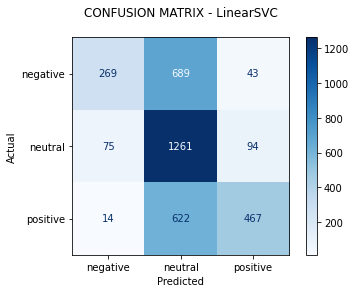

In [16]:
data = confusion_matrix(test['sentiment'], prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=data, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n");
plt.show()

In [24]:
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate

labels = train['sentiment']
features = train_vectors

models = [
    LinearSVC(),
    #SVC(),
    #XGBClassifier(objective='multi:softmax'),
]
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
for model in models:
  model_name = model.__class__.__name__
  scores = cross_validate(model, features, labels, scoring=scoring, cv=CV)
  print(scores.keys())
  print(scores['test_accuracy']) 
  for fold_idx in scores:
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro'])
[0.6790393  0.67449054 0.68322416 0.6786754  0.68286026]


In [19]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.679658,0.003572


In [37]:
print(entries)
print(scores['test_f1_macro'])
print(scores['test_precision_macro'])
print(scores['test_recall_macro'])
print(scores)

[('LinearSVC', 0, 0.6790393013100436), ('LinearSVC', 1, 0.674490538573508), ('LinearSVC', 2, 0.6832241630276564), ('LinearSVC', 3, 0.6786754002911208), ('LinearSVC', 4, 0.6828602620087336)]
[0.6798326  0.67445199 0.68442103 0.68070661 0.68378081]
[0.68564998 0.68059499 0.69046126 0.68413679 0.68855529]
[0.67580938 0.67056248 0.68047986 0.67801472 0.68040293]
{'fit_time': array([0.31543565, 0.57061052, 0.60844588, 0.49075913, 0.30217814]), 'score_time': array([0.10599828, 0.3048718 , 0.27698779, 0.1916604 , 0.1063261 ]), 'test_accuracy': array([0.6790393 , 0.67449054, 0.68322416, 0.6786754 , 0.68286026]), 'test_precision_macro': array([0.68564998, 0.68059499, 0.69046126, 0.68413679, 0.68855529]), 'test_recall_macro': array([0.67580938, 0.67056248, 0.68047986, 0.67801472, 0.68040293]), 'test_f1_macro': array([0.6798326 , 0.67445199, 0.68442103, 0.68070661, 0.68378081])}


In [38]:
list_of_values = []
for fold_idx, accuracy in enumerate(scores['test_accuracy']):
  list_of_values.append((model_name, fold_idx, accuracy, scores['test_f1_macro'] ))
print(list_of_values)

[('LinearSVC', 0, 0.6790393013100436, array([0.6798326 , 0.67445199, 0.68442103, 0.68070661, 0.68378081])), ('LinearSVC', 1, 0.674490538573508, array([0.6798326 , 0.67445199, 0.68442103, 0.68070661, 0.68378081])), ('LinearSVC', 2, 0.6832241630276564, array([0.6798326 , 0.67445199, 0.68442103, 0.68070661, 0.68378081])), ('LinearSVC', 3, 0.6786754002911208, array([0.6798326 , 0.67445199, 0.68442103, 0.68070661, 0.68378081])), ('LinearSVC', 4, 0.6828602620087336, array([0.6798326 , 0.67445199, 0.68442103, 0.68070661, 0.68378081]))]
